# Equatorial Pacific thermal bias and SST bias across ACCESS-OM2 Suite

In [24]:
!cd access-om2-analysis/cosima-scripts/Equatorial_Pacific_Analysis/MOM6/

In [2]:
#Loaaccess-om2-analysis/equired packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from scipy import signal

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [3]:
# Load workers:
client = Client(n_workers=8)
client

distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-84glahp5', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-sj56zq_4', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-uz0xphl3', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-_umjtdgh', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-wm0of3r8', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-utd12767', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/e14/rmh561/tmp/dask-worker-space/worker-gzjsdwf3', purging
distributed.diskutils - INFO - Found stale lock file and direc

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45399,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://127.0.0.1:42461,Total threads: 1
Dashboard: /proxy/44611/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:42281,


In [4]:
session = cc.database.create_session()

In [5]:
# Define experiment dictionary
from collections import OrderedDict
exptdict = OrderedDict([
#    ('1degIAF',   {'model':'ACCESS-OM2 IAF', 'expt':'1deg_jra55_iaf_omip2_cycle6', # 1deg IAF run from Kiss et al. 2020
#                'n_files':None, 'itime':'1998-01-01', 'ftime':None}),
#    ('025degIAF', {'model':'ACCESS-OM2-025 IAF', 'expt':'025deg_jra55_iaf_omip2_cycle6', # 025deg OMIP-2 run
#                'n_files':None, 'itime':'1998-01-01','ftime':None}),
#    ('01degIAF',  {'model':'ACCESS-OM2-01 IAF',  'expt':'01deg_jra55v140_iaf', # 01deg IAF run latest v1.4
#                'n_files':None, 'itime':'1998-01-01','ftime':None}),
    ('1degRYF',   {'model':'ACCESS-OM2 RYF', 'expt':'1deg_jra55_ryf9091_gadi', # 1deg 9091RYF run
                'n_files':-1, 'itime': '2669-01-01','ftime':'2679-01-01'}),
    ('01degRYF',  {'model':'ACCESS-OM2-01 RYF',  'expt':'01deg_jra55v13_ryf9091', # 01deg 9091RYF run
                'n_files':None, 'itime': '2177-01-01','ftime': '2179-01-01'}),
#    ('01degRYF_0Kv',  {'model':'ACCESS-OM2-01 RYF 0Kv',  'expt':'01deg_jra55v13_ryf9091_0Kv', # 01deg 9091RYF run with no Kback
#                'n_files':None, 'itime': '2064-01-01','ftime': '2066-01-01'}),
#    ('01degRYF_5Kv',  {'model':'ACCESS-OM2-01 RYF 5e-6Kv',  'expt':'01deg_jra55v13_ryf9091_5Kv', # 01deg 9091RYF run with 5e-6 Kback
#                'n_files':None, 'itime': '2066-01-01','ftime': '2068-01-01'}),
#    ('025degRYF_1Kv', {'model':'ACCESS-OM2-025 RYF 1e-6Kv', 'expt':'025deg_jra55_ryf_1Kv', # 025deg 9091RYF run 1e-6Kv
#                'n_files':-5, 'itime': '2311-01-01','ftime': '2312-01-01'}),
    ('025degRYF', {'model':'ACCESS-OM2-025 RYF', 'expt':'025deg_jra55_ryf9091_gadi', # 025deg 9091RYF run
                'n_files':None, 'itime': '2539-01-01','ftime': '2549-01-01'}),
    ('OM4_MOM6', {'model':'MOM6 OM4 RYF', 'expt':'OM4_025.JRA_RYF', # MOM6 OM4 run
                'n_files':None, 'itime': '1984-01-01','ftime': '1994-01-01'})
])

In [14]:
var = cc.querying.get_variables(session,experiment= '025_KDS50')

In [6]:
# Add on pre-interpolated WOA13 directories for every run:
for ekey in exptdict.keys():
    e = exptdict[ekey]
    if (ekey.find('025deg') != -1):
        e['WOA13expt'] = '025_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom025.nc'
    elif (ekey.find('01deg') != -1):
        e['WOA13expt'] = '01'
        e['WOA13file'] = 'woa13_ts_??_mom01.nc'
    else:
        e['WOA13expt'] = '10_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom10.nc'

In [43]:
# Adjust times (without deleting all the data by rerunning the exptdict cell above!!!)
exptdict['01degRYF']['itime'] = '2062-01-01'
exptdict['01degRYF_0Kv']['itime'] = '2062-01-01'
exptdict['01degRYF_5Kv']['itime'] = '2062-01-01'
exptdict['01degRYF']['ftime'] = '2063-01-01'
exptdict['01degRYF_0Kv']['ftime'] = '2063-01-01'
exptdict['01degRYF_5Kv']['ftime'] = '2063-01-01'

In [6]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

# Longitude-Depth and Latitude-Depth Slices compared to Johnson et al. 2002

This section includes two sets of longitude-depth and latitude-depth slices - one comparing the thermal and zonal velocity structure between ACCESS-OM2 simulations and the Johnson et al. 2002 observations, and one plotting temperature biases to the WOA13 temperature data set. These types of plots were used in the Kiss et. al GMD paper.

We start by defining the locations of our slices:

In [46]:
depths = (0,300)    # Define depth range for all plots [m]

EqPlons = (-217,-95) # Define longitude range for longitude-depth plot [degrees]
EqPlat = 0.         # Define latitude for longitude-depth plot [degrees]

Ltlon = -140.       # Define longitude for latitude-depth plot [degrees]
ObsLtlon = 220.     # Define longitude for latitude-depth plot for Johnson observations. [degrees]
Ltlats = (-8,10)    # Define latitudes for latitude-depth plot [degrees]

### Define data-extract functions for ACCESS-OM2 data:

Define two functions that extract temperature (in degC) and zonal velocity (in cms-1) data from the ACCESS-OM2 simulations defined above. 

In [47]:
# Define function to extract temperature:
def find_temp(ekey):
    
    # Extract required information from experiment dictionary:
    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime'] # Initial time
    ftime = exptdict[ekey]['ftime'] # Final time
    
    # Define temperature variable using CC (and select correct time slice)
    temp = cc.querying.getvar(expt, 'temp',session,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean.nc',
                             start_time=itime,end_time=ftime)
    
    # Load equatorial longitude-depth slice:
    upper_temp_eq = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=EqPlat, method='nearest')\
                        .sel(xt_ocean=slice(EqPlons[0],EqPlons[1])).mean('time').load() - 273.15
    upper_temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Load latitude-depth slice:
    upper_temp_140w = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=slice(Ltlats[0],Ltlats[1]))\
                        .sel(xt_ocean=Ltlon,method='nearest').mean('time').load() - 273.15
    upper_temp_140w.attrs['units'] = 'degrees Celsius'
    
    return upper_temp_eq, upper_temp_140w

# Define function to extract zonal velocity (note that we multiply by 100 to get units of cms-1):
def find_u(ekey):
    
    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']

    # Define zonal velocity using CC (and select correct time slice)
    u = cc.querying.getvar(expt, 'u',session,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean.nc',frequency='1 monthly')
    
    # Load equatorial longitude-depth slice:
    upper_u_eq = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=EqPlat, method='nearest')\
                        .sel(xu_ocean=slice(EqPlons[0],EqPlons[1])).mean('time').load()*100
    upper_u_eq.attrs['units'] = 'cms-1'
    
    # Load latitude-depth slice:
    upper_u_140w = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=slice(Ltlats[0],Ltlats[1]))\
                        .sel(xu_ocean=Ltlon,method='nearest').mean('time').load()*100
    upper_u_140w.attrs['units'] = 'cms-1'
    
    return upper_u_eq, upper_u_140w

# Define function to extract temperature:
def find_temp_MOM6(ekey):
    
    # Extract required information from experiment dictionary:
    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime'] # Initial time
    ftime = exptdict[ekey]['ftime'] # Final time
    
    # Define temperature variable using CC (and select correct time slice)
    temp = cc.querying.getvar(expt, 'thetao',session, n=n_files,ncfile='ocean_month_z.nc',
                             start_time=itime,end_time=ftime)
    
    # Load equatorial longitude-depth slice:
    upper_temp_eq = temp.sel(z_l=slice(depths[0],depths[1])).sel(yh=EqPlat, method='nearest')\
                        .sel(xh=slice(EqPlons[0],EqPlons[1])).mean('time').load()
    upper_temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Load latitude-depth slice:
    upper_temp_140w = temp.sel(z_l=slice(depths[0],depths[1])).sel(yh=slice(Ltlats[0],Ltlats[1]))\
                        .sel(xh=Ltlon,method='nearest').mean('time').load()
    upper_temp_140w.attrs['units'] = 'degrees Celsius'
    
    return upper_temp_eq, upper_temp_140w

# Define function to extract zonal velocity (note that we multiply by 100 to get units of cms-1):
def find_u_MOM6(ekey):
    
    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']

    # Define zonal velocity using CC (and select correct time slice)
    u = cc.querying.getvar(expt, 'uo',session, n=n_files,ncfile='ocean_month_z.nc',
                             start_time=itime,end_time=ftime)
    
    # Load equatorial longitude-depth slice:
    upper_u_eq = u.sel(z_l=slice(depths[0],depths[1])).sel(yh=EqPlat, method='nearest')\
                        .sel(xq=slice(EqPlons[0],EqPlons[1])).mean('time').load()*100
    upper_u_eq.attrs['units'] = 'cms-1'
    
    # Load latitude-depth slice:
    upper_u_140w = u.sel(z_l=slice(depths[0],depths[1])).sel(yh=slice(Ltlats[0],Ltlats[1]))\
                        .sel(xq=Ltlon,method='nearest').mean('time').load()*100
    upper_u_140w.attrs['units'] = 'cms-1'
    
    return upper_u_eq, upper_u_140w

### Extract Johnson et al. 2002 observational data on the same slices

In [48]:
# Define Johnson observations file:
obs_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')

# Extract temperature:
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

# Extract zonal velocity:
obs_u = obs_file['UM']
obs_u_eq = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_u_140w = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
lon_u_obs = obs_u_eq.XLON

### Plot Equatorial and 140W slices

Now that the data is loaded, we plot it against observations:

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

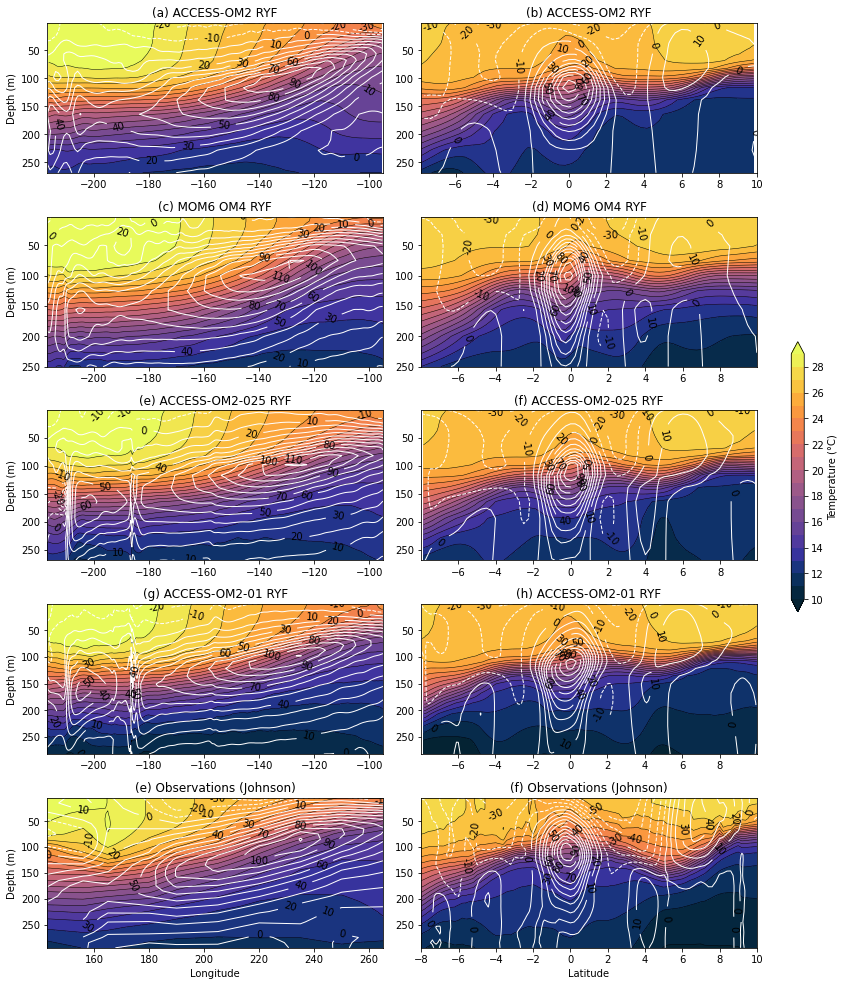

In [49]:
# Define colobar limits and labels:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

labels=['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ','(g) ','(h) ','(i) ','(j) ']

fig = plt.figure(figsize=(12,15))

# Select only a few runs for testing:
ekeys = ['1degRYF','OM4_MOM6','025degRYF','01degRYF']

# Loop over experiments:
for i, ekey in enumerate(ekeys):
    
    if (ekey.find('MOM6')<=0):
        isMOM6 = False
    else:
        isMOM6 = True
    
        # Load data:
    if (isMOM6):
        upper_temp_eq, upper_temp_140w = find_temp_MOM6(ekey)
        upper_u_eq, upper_u_140w = find_u_MOM6(ekey)
    else:
        upper_temp_eq, upper_temp_140w = find_temp(ekey)
        upper_u_eq, upper_u_140w = find_u(ekey)

    # Plot equatorial slice:
    plt.subplot(5,2,2*i+1)
    p1=upper_temp_eq.plot.contourf(cmap=cm.cm.thermal, 
                                   levels=clevelsT,
                                   add_colorbar=False, extend='both')
    upper_temp_eq.plot.contour(colors='k', levels=clevelsT,
                                   add_colorbar=False,linewidths=0.5)
    if (isMOM6):
        xv, yv = np.meshgrid(upper_u_eq.xq,upper_u_eq.z_l)
    else:
        xv, yv = np.meshgrid(upper_u_eq.xu_ocean,upper_u_eq.st_ocean)
    p2=plt.contour(xv,yv,upper_u_eq,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(labels[2*i] + exptdict[ekey]['model'])
    
    # Plot latitude-depth slice:
    plt.subplot(5,2,2*(i+1))
    p3=upper_temp_140w.plot.contourf(cmap=cm.cm.thermal, 
                                     levels=clevelsT,
                                     add_colorbar=False, extend='both')
    upper_temp_140w.plot.contour(colors='k', levels=clevelsT,
                                     add_colorbar=False,linewidths=0.5)
    if (isMOM6):
        xv, yv = np.meshgrid(upper_u_140w.yh,upper_u_140w.z_l)
    else:
        xv, yv = np.meshgrid(upper_u_140w.yu_ocean,upper_u_140w.st_ocean)
    p4=plt.contour(xv,yv,upper_u_140w,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(labels[2*i+1] + exptdict[ekey]['model'])

# Plot observational equatorial slice:
plt.subplot(5,2,9)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
i=i+1
plt.title(labels[i] + 'Observations (Johnson)')

# Plot observational latitude-depth slice:
plt.subplot(5,2,10)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
i=i+1
plt.title(labels[i] + 'Observations (Johnson)')

# Add colorbar:
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical', extend='both')
cb.ax.set_ylabel('Temperature (°C)')
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
savefigure('Equatorial_pacific_RYF_OM4_OM2.png')

## _Results summary:_
- MOM6 appears to have a broader thermocline in the vertical than all the ACCESS-OM2 simulations. 
- MOM6 has a narrower (latitudinally), faster EUC that descends more deeply than ACCESS-OM2 1/4 and 1/10.
- MOM6 has a slightly stronger SEC than ACCESS-OM2-025 and ACCESS-OM2-01.
- The NECC is still really weak (likely linked to JRA-55).
- The deeper EUC is less consistent with the Johnson observations (but this is RYF - treat with caution).

## Plot vertical profiles at the Equator compared to TAO, Johnson and WOA13 data

Here we plot vertical profiles of temperature and zonal velocity from the models and compare to the TAO, Johnson and WOA13 data sets.

The TAO data can be downloaded from https://www.pmel.noaa.gov/tao/drupal/disdel/ and for the locations listed below is sitting in `/g/data/ik11/observations/TAO` directory.

We start out by defining functions to extract profiles from a given longitude from WOA13, TAO and the Johnson data. 


In [7]:
# TAO data extraction function:
obs_th = 2500 # This criteria denotes the minimum number of observations at a given depth required to include this point in the comparison.
def get_TAO(lonTAO):
    # Load temperature:
    tao_file_temp = xr.open_dataset('/g/data/ik11/observations/TAO/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    
    # Load zonal velocity from ADCP data:
    tao_file_u = xr.open_dataset('/g/data/ik11/observations/TAO/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    # Load zonal velocity from current data:
    tao_file_uc = xr.open_dataset('/g/data/ik11/observations/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_uc = tao_uc.where(abs(tao_uc)<=100.)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh
    
# WOA data function:
def get_WOA(lonWOA):
    temp_WOA13_10 = cc.querying.getvar('025_KDS50', 'temp',session).mean('time').sel(GRID_Y_T=0.,method='nearest')
    woa_temp_eq = temp_WOA13_10.sel(GRID_X_T=lonWOA,method='nearest')
    
    return woa_temp_eq

Next we define a function to extract data from the models at a given longitude

In [8]:
def find_Eqpt(ekey,lon):

    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    temp = cc.querying.getvar(expt, 'temp',session,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean.nc',
                             start_time=itime,end_time=ftime)
    temp_eq = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=lon, method='nearest').mean('time').load() - 273.15
    temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Extract velocity
    u = cc.querying.getvar(expt, 'u',session,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean.nc',
                           start_time=itime,end_time=ftime)
    u_eq = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=lon, method='nearest').mean('time').load()*100
    u_eq.attrs['units'] = 'cms-1'
    
    return temp_eq, u_eq

def find_Eqpt_MOM6(ekey,lon):

    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    temp = cc.querying.getvar(expt, 'thetao',session, n=n_files,ncfile='ocean_month_z.nc',
                             start_time=itime,end_time=ftime)
    temp_eq = temp.sel(z_l=slice(depths[0],depths[1])).sel(yh=0., method='nearest')\
                        .sel(xh=lon, method='nearest').mean('time').load()
    temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Extract velocity
    u = cc.querying.getvar(expt, 'uo',session, n=n_files,ncfile='ocean_month_z.nc',
                           start_time=itime,end_time=ftime)
    u_eq = u.sel(z_l=slice(depths[0],depths[1])).sel(yh=0., method='nearest')\
                        .sel(xq=lon, method='nearest').mean('time').load()*100
    u_eq.attrs['units'] = 'cms-1'
    
    return temp_eq, u_eq

Next we define the different longitudes that we wish to plot (since each dataset uses a different type of longitude):

In [9]:
# Define longitudes
lons = {'165e': {'mod': -195.,'tao': '165e','joh': 165.,'woa': -195.},
        '140w': {'mod': -140.,'tao': '140w','joh': 220.,'woa': -140.},
        '110w': {'mod': -110.,'tao': '110w','joh': 250.,'woa': -110.}
        }

Finally, lets plot some profiles

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

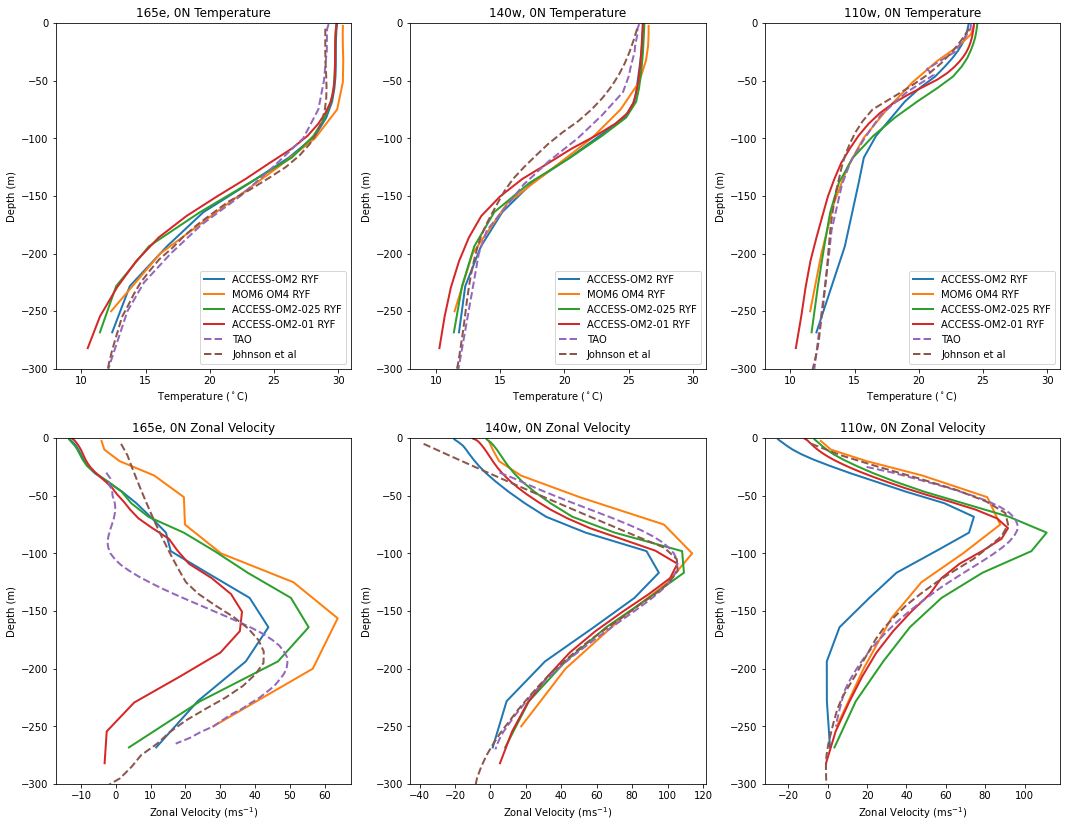

In [53]:
f = plt.figure(figsize=(18,14),facecolor='white')

ekeys = ['1degRYF','OM4_MOM6','025degRYF','01degRYF']#,'OM4_MOM6']
nln = len(lons)
tax = []
uax = []
for j, lkey in enumerate(lons.keys()):
         
    tax.append(plt.subplot(2,nln,j+1))
    uax.append(plt.subplot(2,nln,j+nln+1))

    # Loop through and plot models:
    for i, ekey in enumerate(ekeys):
        if (ekey.find('MOM6')<=0):
            t_eq, u_eq = find_Eqpt(ekey,lons[lkey]['mod'])
            tax[j].plot(t_eq.values,-t_eq.st_ocean.values,label=exptdict[ekey]['model'],linewidth=2)
            uax[j].plot(u_eq.values,-u_eq.st_ocean.values,linewidth=2)
        else:
            t_eq, u_eq = find_Eqpt_MOM6(ekey,lons[lkey]['mod'])
            tax[j].plot(t_eq.values,-t_eq.z_l.values,label=exptdict[ekey]['model'],linewidth=2)
            uax[j].plot(u_eq.values,-u_eq.z_l.values,linewidth=2)        

    # Extract observational data
    tao_temp, tao_u, tao_uc = get_TAO(lons[lkey]['tao'])
    joh_temp_eq, joh_u_eq, dep_joh = get_Joh(lons[lkey]['joh'])
    #woa_temp_eq = get_WOA(lons[lkey]['woa'])
    
    # Ploty observational temperatures
    tax[j].plot(tao_temp.mean('time'),-tao_temp.depth,'--',linewidth=2,label='TAO')
    tax[j].plot(joh_temp_eq,-dep_joh,'--',linewidth=2,label='Johnson et al')
    #tax[j].plot(woa_temp_eq.values,-woa_temp_eq.ZT.values,'--',linewidth=2,label='WOA13')
    tax[j].set_xlabel('Temperature ($^\circ$C)')
    tax[j].set_ylabel('Depth (m)')
    tax[j].legend(loc=4)
    tax[j].set_ylim([-300.,0.])
    tax[j].set_xlim([8.,31.])
    tax[j].set_title(lons[lkey]['tao'] + ', 0N Temperature')
 
    # Plot observational zonal velocities (note, there is no U data from WOA13)
    uax[j].plot(tao_u.mean('time')*100.,-tao_u.depth,'--',linewidth=2) # ADCP data
    # uax[j].plot(tao_uc.mean('time')*100.,-tao_uc.depth,':',linewidth=2) # Current meter data
    uax[j].plot(joh_u_eq*100.,-dep_joh,'--',linewidth=2)
    uax[j].set_xlabel('Zonal Velocity (ms$^{-1}$)')
    uax[j].set_ylabel('Depth (m)')
    uax[j].set_ylim([-300.,0.])
    uax[j].set_title(lons[lkey]['tao'] + ', 0N Zonal Velocity')
    
savefigure('Equatorial_Pacific_profiles_110W_140W_165E_MOM6')

## Results so far:
- Largely consistent with above; MOM6 has a better representation of the thermocline structure at 140W (although still a bit too warm at warm temperatures). 
- EUC is a bit stronger in MOM6 (a bit too strong)?
- In terms of comparing with observations; these are all RYF simulations so I don't think that too much can be read into them.

In any case, the MOM6 simulation is not outside the reasonable range, and there is some evidence that it may do a slightly better job with the thermocline structure (this may be linked to the different placement of vertical levels)? 

[TODO]: A comparison of temperature biases w.r.t. WOA13 would be useful - but requires interpolating the data.

## Meridional structure at 140W:

In [6]:
# Load observational data objects:
OISST = xr.open_mfdataset('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*.nc',concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)
CMEMS = xr.open_mfdataset('/g/data/ua8/CMEMS_SeaLevel/v2019/****/*.nc',concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

In [ ]:
# Note; this analysis is not really needed, it's clear from above that MOM6 still doesn't get the NECC.

lon = -140.
lats = -8., 12.
deps = 0.
dates = '2000-01-01','2017-01-01'

ugeo_obs = CMEMS.ugos.sel(time=slice(dates[0],dates[1])).sel(longitude=lon+360.,method='nearest').sel(latitude=slice(lats[0],lats[1])).mean('time')
temp_oisst = OISST.sst.sel(time=slice(dates[0],dates[1])).sel(lon=lon+360.,method='nearest').sel(lat=slice(lats[0],lats[1])).mean('time')
ssh_obs = CMEMS.adt.sel(time=slice(dates[0],dates[1])).sel(longitude=lon+360.,method='nearest').sel(latitude=slice(lats[0],lats[1])).mean('time')
ssh_obs=ssh_obs-ssh_obs.mean('latitude')

ekeys = ['1degRYF','OM4_MOM6','025degRYF','01degRYF']
for i, ekey in enumerate(ekeys):
    if (ekey.find('MOM6')<=0):
        tmp = cc.querying.getvar(expdict[ekey]['expt'], 'uo',session, start_time=exptdict[ekey]['itime'],end_time=exptdict[ekey]['ftime'])
        expdict[ekey]['u140w'] = tmp.sel(xq=lon,method='nearest').sel(yh=slice(lats[0],lats[1])).sel(z_l=deps,method='nearest').mean('time')
        
        tmp = cc.querying.getvar(expdict[ekey]['expt'], 'thetao',session, start_time=exptdict[ekey]['itime'],end_time=exptdict[ekey]['ftime'])
        expdict[ekey]['T140w'] = tmp.sel(xh=lon,method='nearest').sel(yh=slice(lats[0],lats[1])).sel(z_l=deps,method='nearest').mean('time')
        
        tmp = cc.querying.getvar(expdict[ekey]['expt'], 'thetao',session, start_time=exptdict[ekey]['itime'],end_time=exptdict[ekey]['ftime'])
        expdict[ekey]['Z140w'] = tmp.sel(xh=lon,method='nearest').sel(yh=slice(lats[0],lats[1])).sel(z_l=deps,method='nearest').mean('time')
    else:
        tmp = cc.querying.getvar(expdict[ekey]['expt'], 'u',session, start_time=exptdict[ekey]['itime'],end_time=exptdict[ekey]['ftime'])
        expdict[ekey]['u140w'] = tmp.sel(xu_ocean=lon,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')
        
        tmp = cc.querying.getvar(expdict[ekey]['expt'], 'temp',session, start_time=exptdict[ekey]['itime'],end_time=exptdict[ekey]['ftime'])
        expdict[ekey]['T140w'] = tmp.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')
        
        tmp = cc.querying.getvar(expdict[ekey]['expt'], 'temp',session, start_time=exptdict[ekey]['itime'],end_time=exptdict[ekey]['ftime'])
        expdict[ekey]['Z140w'] = tmp.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')
        
# subtract mean:
ssh01=ssh01-ssh01.mean('yt_ocean')
ssh025=ssh025-ssh025.mean('yt_ocean')
#ssh_soda=ssh_soda-ssh_soda.mean('yt_ocean')

## SST/SSH variance, TIWs:

In [7]:
# Select regions for high-pass longitude filtered analysis:
ln_hp_filt = 12.0

xr = -170.,-100.
xrf = xr[0]-ln_hp_filt/2.,xr[1]+ln_hp_filt/2.
yr = -2.,10.

expt = exptdict['OM4_MOM6']['expt']
itime = '1992-01-01'
ftime = '1994-01-01'

sst = cc.querying.getvar(expt, 'tos',session, start_time=itime,end_time=ftime,ncfile='ocean_daily.nc')
ssh = cc.querying.getvar(expt, 'zos',session, start_time=itime,end_time=ftime,ncfile='ocean_daily.nc')
sst = sst.sel(xh=slice(xrf[0],xrf[1])).sel(yh=slice(yr[0],yr[1]))
ssh = ssh.sel(xh=slice(xrf[0],xrf[1])).sel(yh=slice(yr[0],yr[1]))

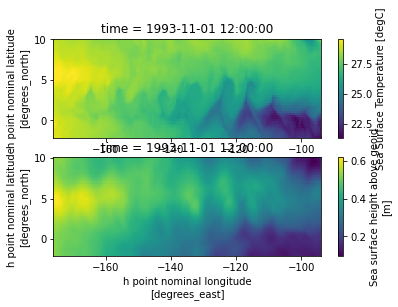

In [13]:
plt.subplot(2,1,1)
sst.sel(time='1993-11-01').plot()
plt.subplot(2,1,2)
ssh.sel(time='1993-11-01').plot()

In [ ]:
# Do high-pass filtering:
sst_hp = (sst-sst.rolling(xh=int(ln_hp_filt/(1./4.)),center=True).mean())
sst_hp_std = sst_hp.std('time')
sst_hp_std.load()

In [ ]:
ssh_hp = (ssh-ssh.rolling(xh=int(ln_hp_filt/(1./4.)),center=True).mean())
ssh_hp_std = ssh_hp.std('time')
ssh_hp_std.load()

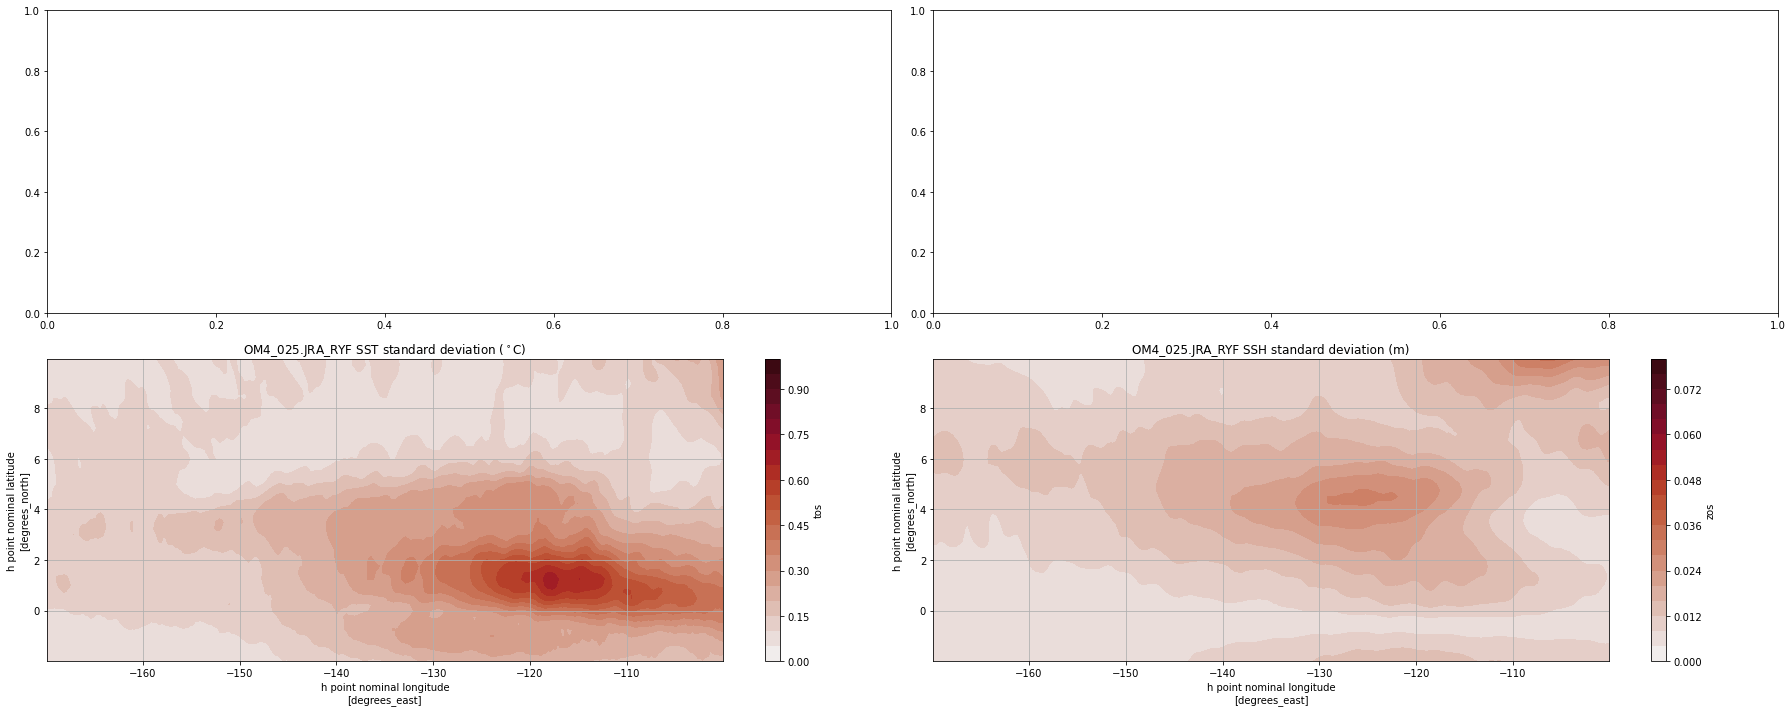

In [19]:
tlims = 0.,1.
zlims = 0.,0.08
tsp = tlims[1]/20.
zsp = zlims[1]/20.

# Do the plotting:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
sst_hp_std.sel(xh=slice(xr[0],xr[1])).plot.contourf(ax=axes[1][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
ssh_hp_std.sel(xh=slice(xr[0],xr[1])).plot.contourf(ax=axes[1][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
    
axes[1][0].set_title(expt + ' SST standard deviation ($^\circ$C)')
axes[1][1].set_title(expt + ' SSH standard deviation (m)')
axes[1][0].grid()
axes[1][1].grid()
plt.tight_layout()
plt.savefig('SSH_SST_FiltPlot_MOM6.png',dpi=300)

## Equivalent plot from Observations, ACCESS-OM2-025 OMIP-2 and ACCESS-OM2-01 IAF run (2009-2019)
<img src="../TIWs/SSH_SST_FiltPlot_01deg_025deg.png" alt="Drawing" style="width: 500px;"/>

## Results:
- MOM6 still has much lower SST and SSH variability associated with TIWs than observations (likely linked to the lack of an NECC, which is likely linked to the JRA-55 forcing).
- However, it seems to do a better job than ACCESS-OM2-025 (if comparisons between RYF and IAF can be trusted) - in particular with a stronger peak in SSH variability near 4N.